In [2]:
# MNIST 데이터셋 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# data: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가짐
# target: 레이블 배열을 담음

X, y = mnist["data"], mnist["target"]
print("X: ", X.shape) # 이미지가 28x28 픽셀이므로 784개의 특성이 존재
print("y: ", y.shape)

X:  (70000, 784)
y:  (70000,)


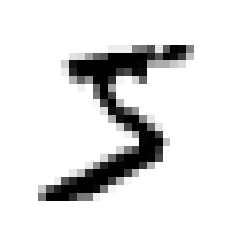

In [4]:
# 샘플의 특성 벡터를 추출해서 28x28 배열로 크기를 바꾸어 데이터 셋에서 이미지 확인
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [5]:
# 실제 레이블 확인
y[0]

'5'

In [6]:
# 레이블은 문자열이기 때문에 y를 정수로 변환
import numpy as np

y = y.astype(np.uint8)

In [7]:
# 훈련 세트 나누기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
# 이진 분류기 훈련
# 분류 작업을 위해 타깃 벡터 생성
y_train_5 = (y_train == 5) # 5면 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

In [9]:
# 확률적 경사 하강법(SGD) 분류기로 훈련
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
# 모델을 사용해 숫자 5의 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

### 정확도를 통한 성능 측정

In [11]:
# 교차 검증을 사용한 정확도 측정
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42) # 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행하고, 매 반복에서 분류기 객체를 복제하여 훈련 폴드를 훈련 시킨 다음 테스트 폴드로 예측을 만듦

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/Users/ChaeEun/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


In [12]:
# 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델 평가
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

### 오차행렬을 통한 성능 측정

In [15]:
# 오차행렬을 만들기 위해 예측값 만들기
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3) # k-겹 교차 검증을 수행하지만 각 테스트 폴드에서 얻은 예측 반환

# 오차행렬 만들기
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
# 완벽한 분류기일 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 분류기 지표 계산

In [17]:
# 정밀도
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
# 재현율
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
# F1 스코어
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [20]:
# decision_function() 메서드를 사용하여 각 샘플의 점수를 확인
# 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있음

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
# 임곗값이 0일 경우 = predict() 메서드와 같은 결과를 변환
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
# 임곗값이 8000일 경우
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [23]:
# 적절한 임곗값 정하기

# cross_val_predict() 함수를 이용해 훈련 세트에 있는 모든 샘플의 점수 구하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

/Users/ChaeEun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ChaeEun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


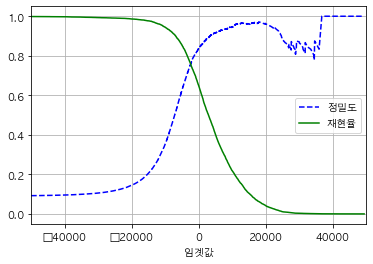

In [25]:
# precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve
import os
os.name
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
    
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label = "재현율")
    plt.grid(True)
    plt.xlim(-50000, 50000)
    plt.xlabel("임곗값")
    plt.legend()


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [50]:
# 정밀도 90%인 임곗값 찾기
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

In [51]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [52]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [53]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### ROC 곡선

In [54]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

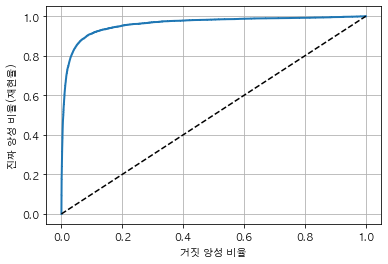

In [56]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.xlabel("거짓 양성 비율")
    plt.ylabel("진짜 양성 비율(재현율)")
    plt.grid(True)
    
plot_roc_curve(fpr, tpr)
plt.show()

In [57]:
# 곡선 아래의 면적(AUC) 측정
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### RandomForestClassifier

In [58]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)

# decision_function() 대신 predict_proba() 사용
# predict_proba(): 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

In [60]:
# ROC 커브
# 양성 클래스 확률을 점수로 사용

y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

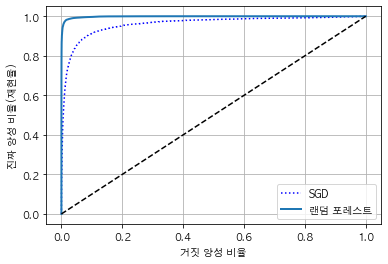

In [61]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc = "lower right")
plt.show()

In [62]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### OvR / OvO 실행

In [63]:
# 서포트 벡터 머신 분류기 테스트 --> OvO 전략 사용
from sklearn.svm import SVC
svm_clf = SVC() # 0~9까지 SVC 훈련
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [64]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [65]:
np.argmax(some_digit_scores)

5

In [66]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [67]:
svm_clf.classes_[5]

5

In [68]:
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [69]:
len(ovr_clf.estimators_)

10

In [70]:
# SGDClassifier 훈련

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [71]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [72]:
# SGDClassifier 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [73]:
# 성능 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

### 에러 분석

In [74]:
# 오차 행렬을 통해 에러 분석
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

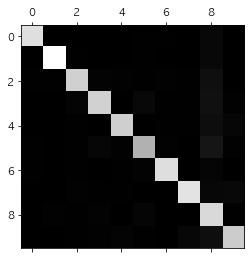

In [75]:
# 오차 행렬을 이미지로 표현
# 배열에서 가장 큰 값은 흰색으로, 가장 작은 값은 검은색으로 정규화되어 그려짐
# 숫자 5는 조금 더 어둡기 때문에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한 다는 것을 뜻함
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [76]:
# 에러 비율 비교
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

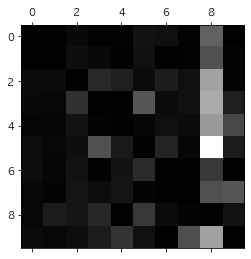

In [79]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

In [83]:
# plot_digits 정의
import matplotlib

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

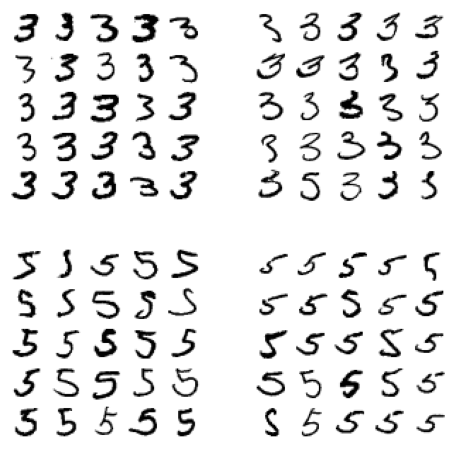

In [84]:
# 3과 5의 샘플을 통해 에러 분석
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

### 다중 레이블 분류

In [85]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [93]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [94]:
# 모든 레이블에 대한 F1 점수의 평균을 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.976410265560605

### 다중 출력 분류

In [95]:
# 이미지에서 잡음을 제거하는 시스템 생성
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

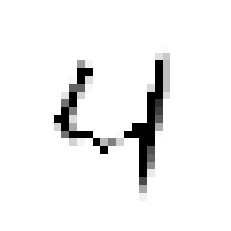

In [98]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[4]])
plot_digits(clean_digit)